In [1]:
# Import libraries
import numpy as np
import os , csv
from os import listdir
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.interpolate import interp1d
from sklearn.decomposition import TruncatedSVD

recording along 748 channels
brain areas recorded in that animal
['MOs' 'MRN' 'OLF' 'ORB' 'PAG' 'RSP' 'SCm' 'SCs' 'root']
number of clusters in cluster_idx => 778
number of "good" and "unsorted" clusters in cluster_idx => 522
number of clusters in spikeclusters => 778
Number of clean clusters in frontal_circuits => 222
Number of clean clusters in mid_brain_circuits => 194


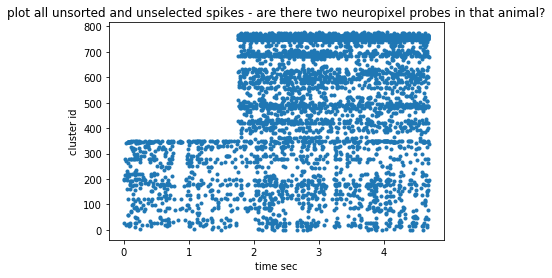

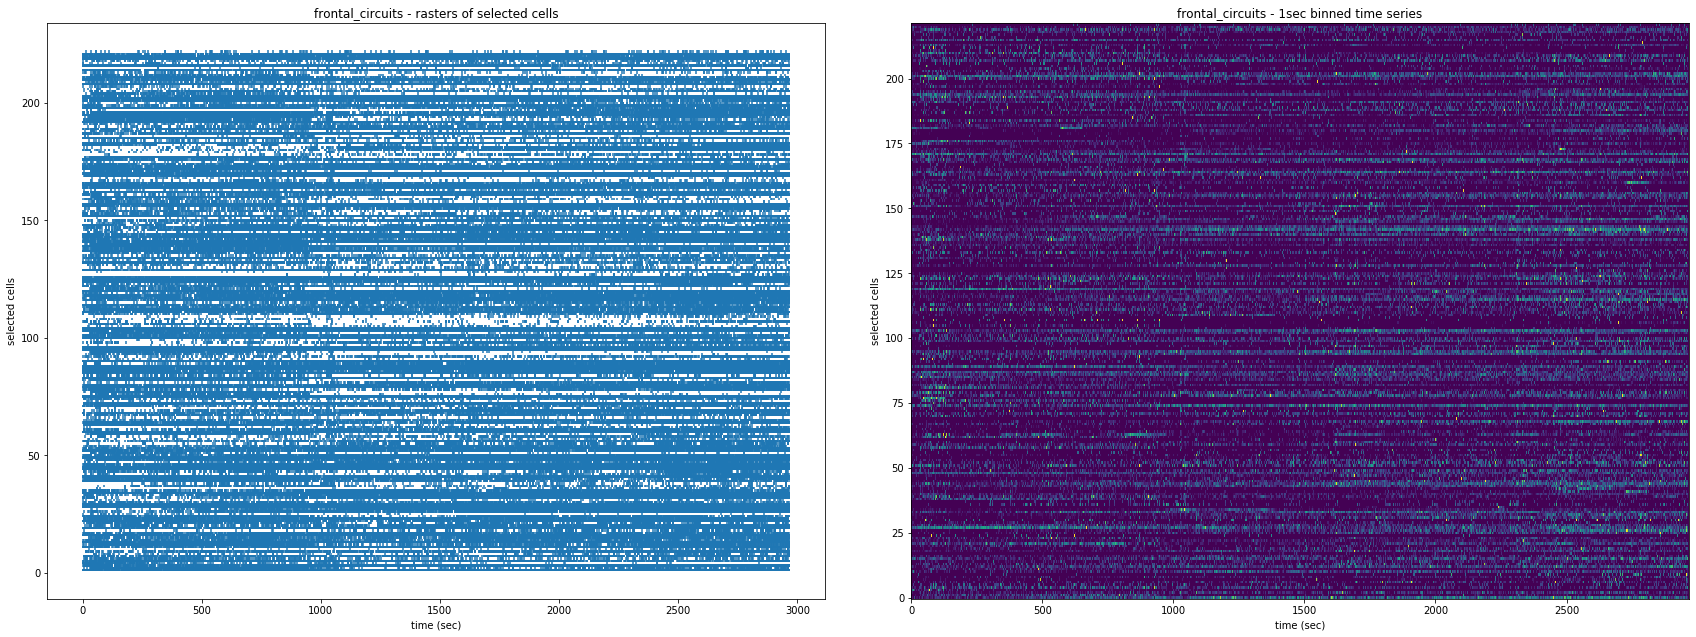

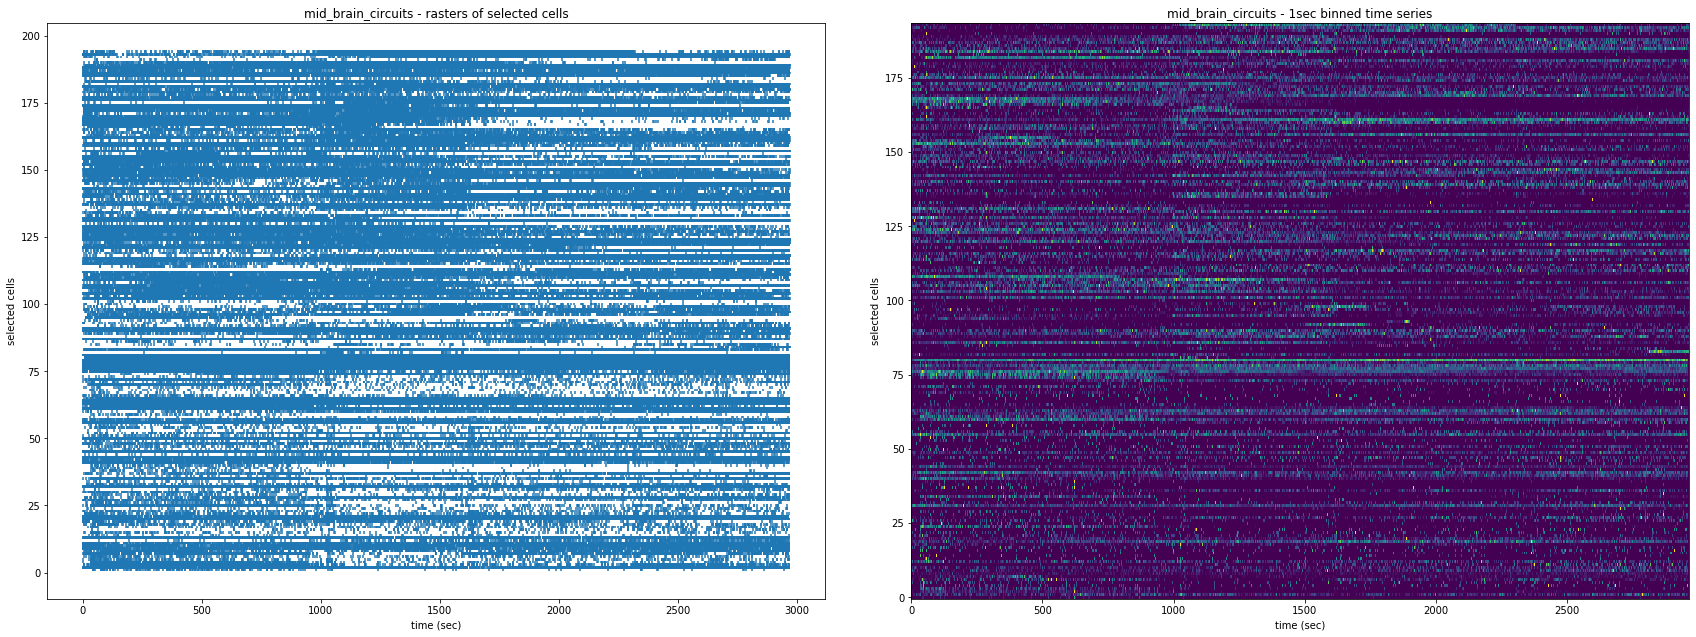

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### get area from clusters idx
def get_area_from_clusters(cluster_idx,all_data_path, selected_recordings):
    cluster_peakChannel =  np.load(all_data_path +'/'+selected_recordings+'/'+'clusters.peakChannel.npy')
    individualchannel_location = pd.read_csv(all_data_path +'/'+selected_recordings+'/'+'channels.brainLocation.tsv', sep='\t')
    individualchannel_location = individualchannel_location.allen_ontology;
    
    channellocation = cluster_peakChannel[cluster_idx]
    area = np.array(individualchannel_location[channellocation])
   
    return area


### get the clean clusters
def get_clean_clusters(cluster_quality):
    ## cluster indices from "good spikes" from the 'clusters' objects 
    print('number of clusters in cluster_idx => '+str(len(cluster_quality)))
    
    # 0 = noise (these are already excluded and don't appear in this dataset at all); 
    # 1 = MUA (i.e. presumed to contain spikes from multiple neurons; 
    # these are not analyzed in any analyses in the paper); 
    # 2 = Good (manually labeled); 3 = Unsorted. 
    # In this dataset 'Good' was applied in a few but not all datasets to included neurons, 
    # so in general the neurons with _phy_annotation>=2 are the ones that should be included.
    clusters_idx = np.arange(len(cluster_quality))
    cluster_good_where = np.where(cluster_quality>=2);
    cluster_good_where = cluster_good_where[0]
    good_and_unsorted_clusters = clusters_idx[cluster_good_where]
    print('number of "good" and "unsorted" clusters in cluster_idx => '+ str(len(good_and_unsorted_clusters)))
    
    return good_and_unsorted_clusters





def get_population_timeseries_matrices(listsofareas, labels, binning_resolution_sec=1, 
                                       all_data_path='/media/maria/DATA1/Documents/NeuroMatchAcademy2020_dat/unzipped_files', 
                                       selected_recordings= 'Richards_2017-10-31.tar'):
    '''
    # inputs --> lists of area ; N list of areas as many as you want (see example below)
    # returns --> All_binned_timeseries as N arrays in one array
    
    
    ## how to use it 
    ## define cluster of brain areas
    mid_brain_circuits=['SCs','SCm','MRN','APN','PAG','ZI']
    frontal_circuits=['MOs','PL','ILA','ORB','MOp','SSp']
    population_matrices = get_population_timeseries_matrices([mid_brain_circuits,
                                                                frontal_circuits], 
                                                             binningresol_sec = 1, 
                                                             all_data_path='/Users/jean/git/steinmetz-et-al-2019/data', 
                                                             selected_recordings= 'Richards_2017-10-31')
                                                             
    Then from the output, individual matrices can be extrcated as follows:
    FrontalMatrix = population_matrices[0][0]
    MidBrainMatrix = population_matrices[1][0]
    
    '''
    
    ## identify brain areas recorded by individual channels
    individualchannel_location = pd.read_csv(all_data_path +'/'+selected_recordings+'/'+'channels.brainLocation.tsv', sep='\t')
  
    # allen_ontology [enumerated string] (nChannels) The acronym of the brain region determined to contain this channel in the Allen CCF.
    #individualchannel_lat_position = individualchannel_location.ccf_lr;
    individualchannel_location = individualchannel_location.allen_ontology;
    individualchannel_location = np.array(individualchannel_location)
    print('recording along '+ str(len(individualchannel_location)) +' channels')
    print('brain areas recorded in that animal')
    print(np.unique(individualchannel_location))
    
    ## get good_and_unsorted_clusters
    cluster_quality = np.load(all_data_path +'/'+selected_recordings+'/'+'clusters._phy_annotation.npy')
    good_and_unsorted_clusters = get_clean_clusters(cluster_quality)
    
    ## area of good_and_unsorted_clusters
    cluster_area = []
    for q in good_and_unsorted_clusters:
        that_cluster_area = get_area_from_clusters(q,all_data_path, selected_recordings)
        cluster_area.append(that_cluster_area[0])
#     print(str(len(cluster_area)))
          
    ## spikes and cluster idx from the 'spikes' object
    spiketimes = np.load(all_data_path +'/'+selected_recordings+'/'+'spikes.times.npy')
    spikeclusters = np.load(all_data_path +'/'+selected_recordings+'/'+'spikes.clusters.npy')
    ## to check if it corresponds to clusters class
    ## the numbers in there match raws of the cluster objects (see below)
    uniquespikeclusters = np.unique(spikeclusters)
    print('number of clusters in spikeclusters => '+str(len(uniquespikeclusters)))
    
    # ploting the 5000 nth spikes, picked from all the clusters
    firstspiketoplot = 0
    numberofspikestoplot = 5000
    idtoplot = np.arange(firstspiketoplot, firstspiketoplot+numberofspikestoplot)
    plt.plot(spiketimes[idtoplot], spikeclusters[idtoplot], '.')
    plt.xlabel('time sec')
    plt.ylabel('cluster id')
    plt.title('plot all unsorted and unselected spikes - are there two neuropixel probes in that animal?')
    
    ## returns as many population matrices as len(listsofareas)
    ## each population matrix is a N cells X ~ duration/binningresol_sec array
    All_binned_timeseries = []
    All_clusters=[]
    All_Areas=[]
    for brainareaidx in np.arange(len(listsofareas)):
        
        BrainArea = listsofareas[brainareaidx]

        ### find clean units from the right areas
        logical_goodclustersinrightarea = np.zeros(len(cluster_area)) 
        for ThatRegOIfInt in BrainArea:
            for ar in np.arange(len(cluster_area)):
                if cluster_area[ar] == ThatRegOIfInt:
                    logical_goodclustersinrightarea[ar]=1
    
        clean_Clusters_InTheRightArea = np.where(logical_goodclustersinrightarea==1)[0]
        print('Number of clean clusters in '+labels[brainareaidx]+ ' => '+str(len(clean_Clusters_InTheRightArea)))
    
        # timeseries
        #binning_resolution_sec = 20 #sec 
        numberofbins = int(round(np.max(spiketimes)/binning_resolution_sec)); #
        #print(numberofbins)
        bins = np.linspace(0, int(np.max(spiketimes)+1), numberofbins)
        #print(np.max(spiketimes))
        #bins.shape
        FigRaster = plt.figure() # initializing figure rasters
        FigRasterAx = FigRaster.add_axes([0.1, 0.1, 1.8, 2])
        ## preallocating
        binned_timeseries = np.zeros((len(clean_Clusters_InTheRightArea), len(bins)-1))

        ## iteratively selecting spikes from distinct cluster and generating an array of N arrays for N cells
        for thatspike in np.arange(len(clean_Clusters_InTheRightArea)):
            #print(clean_Clusters_InTheRightArea[thatspike])
            #length(clean_Clusters_InTheRightArea[thatspike])
            those_spike_indices = (spikeclusters == clean_Clusters_InTheRightArea[thatspike])
            #print(spiketimes[those_spike_indices])
            FigRasterAx.eventplot(spiketimes[those_spike_indices], lineoffsets=thatspike+1)

            # building histogram --> 20 ms binning of the data
            # starting at time = 0 to max(spiketimes)
            binned_timeseries[thatspike,:], bin_edges = np.histogram(spiketimes[those_spike_indices], bins, density=True) 


        bin_center = bin_edges[:-1] + (np.min(np.diff(bin_edges))/2)

        FigRasterAx.set_ylabel('selected cells')
        FigRasterAx.set_xlabel('time (sec)')
        FigRasterAx.set_title(labels[brainareaidx]+' - rasters of selected cells')
        FigRasterAx.axis('tight')

        ## visualising time series color plot
        #FigTimeSeries = plt.figure() # initializing figure TimeSeries
        FigTimeSeriesAx = FigRaster.add_axes([2.1, .1, 1.8, 2])
        MaxOfRows = np.max(binned_timeseries, axis=1);
        Normalizationfordisplay = binned_timeseries/MaxOfRows[:,None]
        FigTimeSeriesAx.imshow(Normalizationfordisplay)
        FigTimeSeriesAx.axis('tight')
        FigTimeSeriesAx.set_ylabel('selected cells')
        FigTimeSeriesAx.set_xlabel('time (sec)')
        FigTimeSeriesAx.set_title(labels[brainareaidx]+' - '+str(binning_resolution_sec)+'sec binned time series')
        FigTimeSeriesAx.invert_yaxis()
        
        All_clusters.append([clean_Clusters_InTheRightArea])
        
#         allareas = np.arange(len(clean_Clusters_InTheRightArea))
#         for cl in clean_Clusters_InTheRightArea:
#             allareas[cl] = get_area_from_clusters(cl)
#         All_Areas.append([area])
        All_binned_timeseries.append([binned_timeseries])
        
         
    return All_binned_timeseries
    
#### Example on how use it 
## define cluster of brain areas
mid_brain_circuits=['SCs','SCm','MRN','APN','PAG','ZI']
frontal_circuits=['MOs','PL','ILA','ORB','MOp','SSp']
        
population_matrices = get_population_timeseries_matrices([frontal_circuits, mid_brain_circuits], 
                                                         labels=['frontal_circuits', 'mid_brain_circuits'], 
                                                         binning_resolution_sec = 1)

# population_matrices = get_population_timeseries_matrices([['SCs'],['SCm'],['MRN'],['APN'],['PAG'],['ZI'], ['MOs'],['PL'],['ILA'],['ORB'],['MOp'],['SSp']],
#                                                          labels=['SCs','SCm','MRN','APN','PAG','ZI', 'MOs','PL','ILA','ORB','MOp','SSp'], 
#                                                          binning_resolution_sec = 20)
FrontalMatrix = population_matrices[0][0]
MidBrainMatrix = population_matrices[1][0]

In [9]:
print(FrontalMatrix.shape)
print(MidBrainMatrix.shape)

(222, 2967)
(194, 2967)


In [10]:
from sklearn import mixture
clf = mixture.GaussianMixture(n_components=5, covariance_type='full')
clf.fit(MidBrainMatrix)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

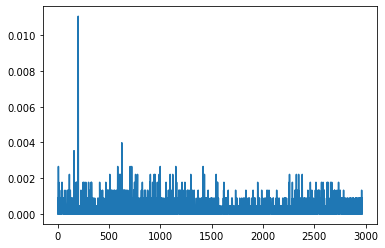

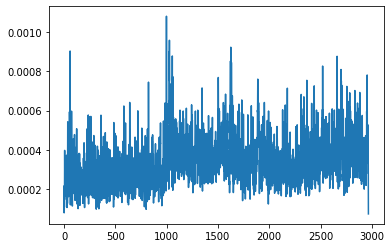

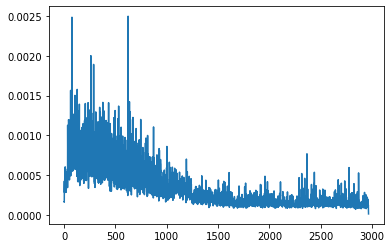

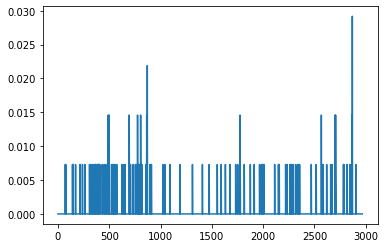

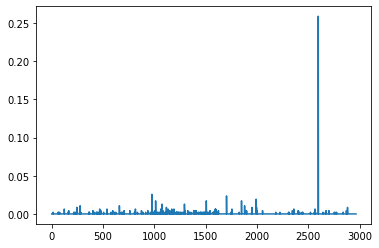

In [26]:
clf.means_.shape
i=0
for j in range(0,5):
    plt.plot(clf.means_[j,:])
    plt.show()
    

(2967, 10)


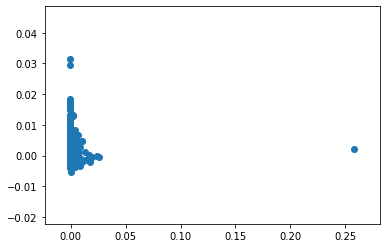

In [15]:
from sklearn.decomposition import PCA

pca=PCA(n_components=10)

pcs=pca.fit_transform(MidBrainMatrix.T)

print(pcs.shape)
plt.scatter(pcs[:,0],pcs[:,1])

In [4]:
from sklearn import mixture
clf_mid = mixture.GaussianMixture(n_components=5, covariance_type='full')
clf_mid.fit(MidBrainMatrix)

clf_front=mixture.GaussianMixture(n_components=5, covariance_type='full')
clf_front.fit(FrontalMatrix)

np.corrcoef(clf_mid.means_,clf_front.means_)

array([[ 1.00000000e+00,  3.38880605e-02, -8.83644974e-02,
        -1.35395942e-01, -2.54068334e-01,  3.10386734e-01,
         7.42184300e-02,  3.37572568e-01,  4.80253717e-02,
         1.11356174e-01],
       [ 3.38880605e-02,  1.00000000e+00, -1.29986093e-02,
        -5.65778502e-03, -9.74325792e-03, -9.22404326e-03,
        -8.88229316e-03, -2.06710729e-02, -1.02506738e-02,
         1.98443314e-02],
       [-8.83644974e-02, -1.29986093e-02,  1.00000000e+00,
         8.98134135e-02,  2.58280549e-01, -4.83128641e-02,
         2.45075621e-03,  1.27430339e-01,  3.85477442e-02,
        -1.58677296e-02],
       [-1.35395942e-01, -5.65778502e-03,  8.98134135e-02,
         1.00000000e+00,  2.65169099e-01, -7.60205180e-02,
         4.27894747e-04,  2.06843302e-02,  3.34814682e-02,
        -1.36987720e-02],
       [-2.54068334e-01, -9.74325792e-03,  2.58280549e-01,
         2.65169099e-01,  1.00000000e+00, -1.85846723e-01,
        -5.35852945e-03,  3.44319459e-01,  1.48164023e-01,
        -3.

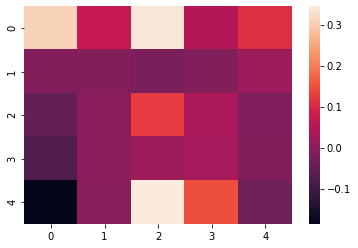

In [17]:
import seaborn as sns
from scipy.stats import pearsonr

corr_arr=np.zeros((5,5))
for j in range(0,5):
    for i in range(0,5):
        corr_arr[j,i]=pearsonr(clf_mid.means_[j,:],clf_front.means_[i,:])[0]
sns.heatmap(corr_arr)